# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

*There were total of 52944 phone contacts from May 2008 to June 2013.*

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [68]:
import pandas as pd
import numpy as np
import time

# data viz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("fivethirtyeight") # styling your charts 

# pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# modeling
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance 

# evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 

import warnings
warnings.filterwarnings('ignore')

print("All modules loaded")

All modules loaded


In [69]:
df = pd.read_csv('data/bank-additional/bank-additional-full.csv', sep = ';')

In [70]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [72]:
df.shape

(41188, 21)

In [73]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [74]:
df.duplicated().sum()

12

In [75]:
df.drop_duplicates(inplace  = True)

In [76]:
df.shape

(41176, 21)

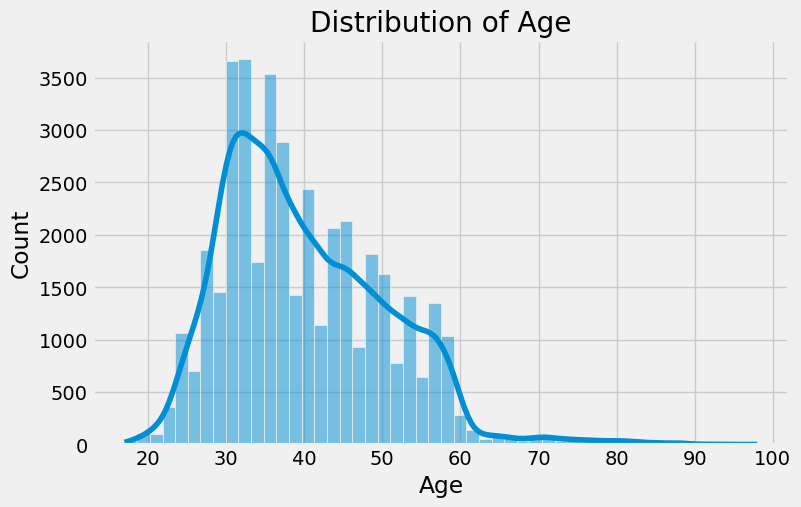

In [77]:
# Plot the distribution of the 'age' column
plt.figure(figsize=(8, 5))
sns.histplot(df['age'], bins=50, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

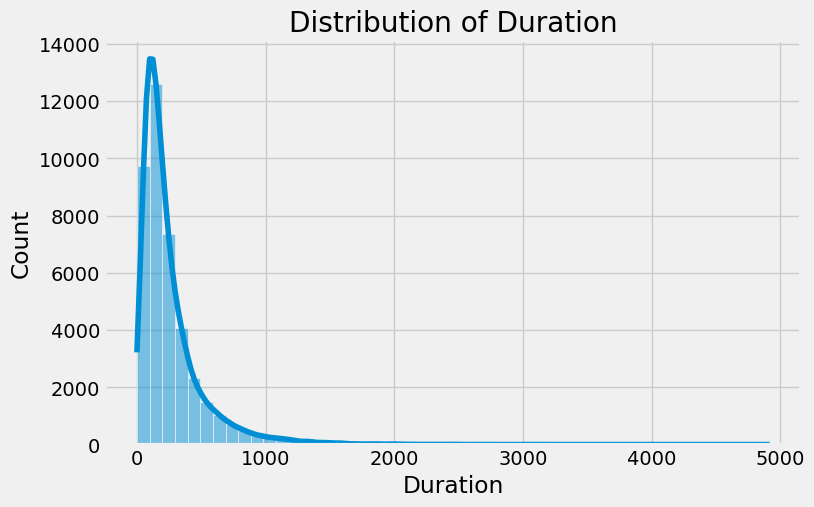

In [78]:
# Plot the distribution of the 'duration' column
plt.figure(figsize=(8, 5))
sns.histplot(df['duration'], bins=50, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
plt.show()

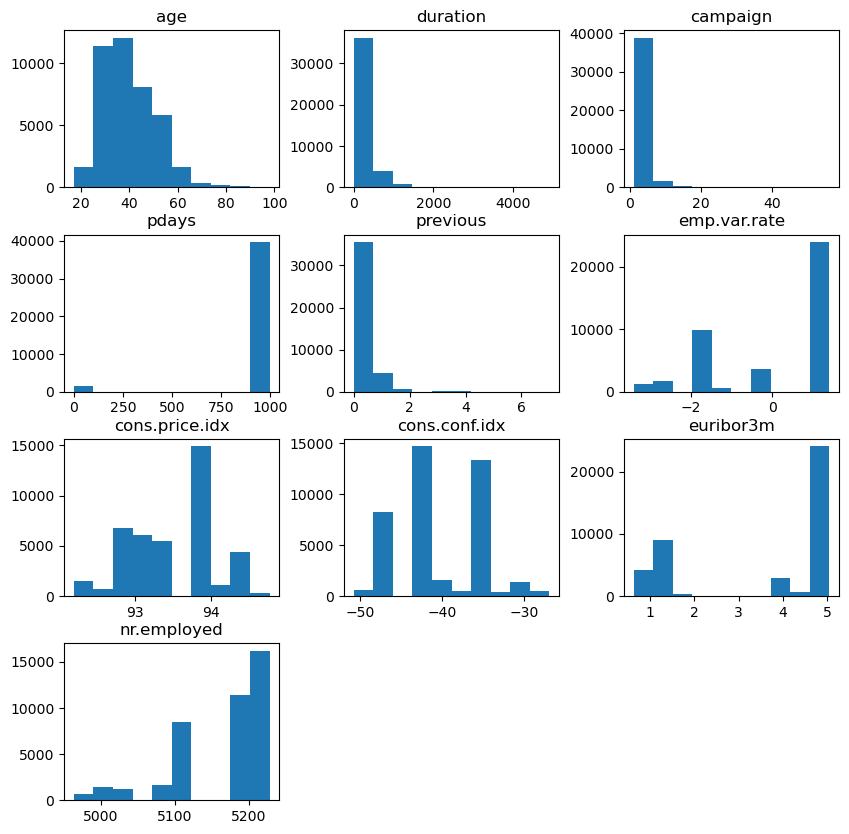

In [79]:
plt.style.use('default')
df.hist(figsize = (10, 10), grid=False);

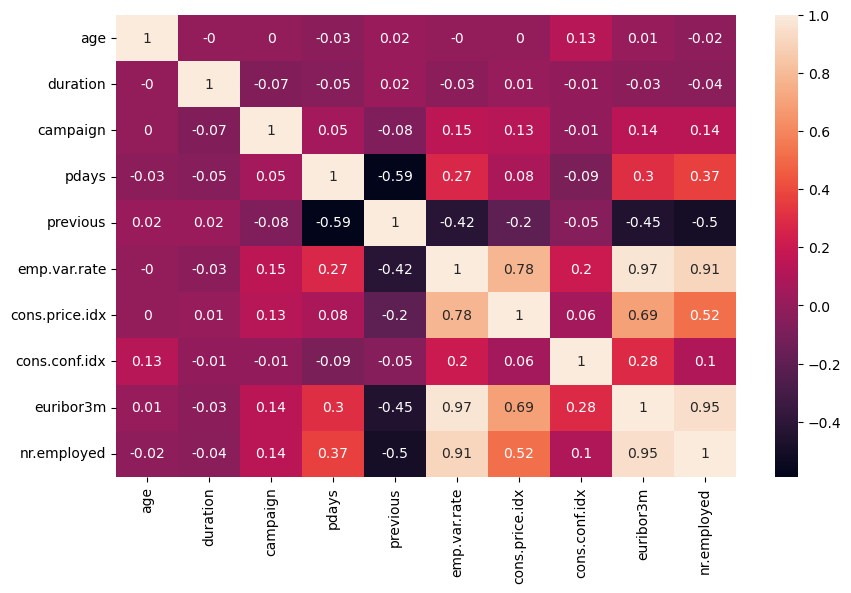

In [80]:
corr = df.corr(numeric_only = True).round(2)

# plot the heatmap
plt.figure(figsize = (10, 6))

#viz the heatmap
sns.heatmap(corr, annot= True);

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [81]:
# Define features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [82]:
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [83]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [85]:
# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [86]:
# Create a function that can be re-used to run the pipeline with different models and store the result

results = []
def RunPipeline(name, pipeline):
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = (time.time() - start_time) 

    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)

    # Append the results
    results.append([name, train_time, train_score, test_score])

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [87]:
# Create the pipeline: basic model for Logistic Regression
pipelineBasicLR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])

In [88]:
# Empty the result for the first model run!
results = []
RunPipeline("LogisticRegression", pipelineBasicLR)

### Problem 9: Score the Model

What is the accuracy of your model?

In [89]:
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.362987,0.913206,0.906265


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [90]:
# Create the pipeline: basic model for Decision Tree
pipelineBasicDT = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier())
])

# Create the pipeline: basic model for KNN
pipelineBasicKNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# Create the pipeline: basic model for SVC
pipelineBasicSVC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC())
])

# Create the pipeline: basic model for RandomForestClassifier
pipelineBasicRF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

In [91]:
RunPipeline("DecisionTree", pipelineBasicDT)
RunPipeline("KNN", pipelineBasicKNN)
RunPipeline("SVC", pipelineBasicSVC)
RunPipeline("RandomForest", pipelineBasicRF)

In [92]:
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.362987,0.913206,0.906265
DecisionTree,0.290176,1.000000,0.891209
KNN,0.073650,0.928658,0.896916
SVC,9.280860,0.922920,0.908694
RandomForest,1.913479,0.999939,0.909786


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [93]:
# Create a function that can be re-used to run the GridSearchCV pipeline with different models and store the result

resultsGridSearch = []
def RunPipelineGridSearch(name, pipeline, params):
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])

    # Get the best estimator
    best_model = grid_search.best_estimator_
    
    # Evaluate on training and test sets
    train_score = best_model.score(X_train, y_train)
    test_score = best_model.score(X_test, y_test)

    # Append the results
    resultsGridSearch.append([name, train_time, train_score, test_score, best_model])

In [94]:
# Create the pipeline: GridSearchCV for Logistic Regression
pipelineGridSearchLR = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000) )
])
paramGridSearchLR = { 'model__C': [0.1, 1, 10, 100], 
                      'model__penalty': ['l1', 'l2', 'elasticnet', 'None'], 
                      'model__solver': ['liblinear', 'saga'] }

In [95]:
RunPipelineGridSearch("LogisticRegression", pipelineGridSearchLR, paramGridSearchLR)

In [96]:
# Create the pipeline: GridSearchCV for Decision Tree
pipelineGridSearchDT = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier() )
])
paramGridSearchDT = { 'model__max_depth': [5, 10, 15, 20, 30], 
                      'model__criterion': ['gini', 'entropy'] }

In [97]:
RunPipelineGridSearch("DecisionTree", pipelineGridSearchDT, paramGridSearchDT)

In [98]:
# Create the pipeline: GridSearchCV for KNN
pipelineGridSearchKNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier() )
])
paramGridSearchKNN = { 'model__n_neighbors': [3, 5, 7, 9], 
                       'model__weights': ['uniform', 'distance'] }

In [99]:
RunPipelineGridSearch("K-Nearest Neighbour", pipelineGridSearchKNN, paramGridSearchKNN)

In [100]:
# Create the pipeline: GridSearchCV for SVC
pipelineGridSearchSVC = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC() )
])
paramGridSearchSVC = { 'model__C': [0.1, 1, 10], 
                       'model__kernel': ['rbf', 'poly', 'linear', 'sigmoid'] }

In [101]:
RunPipelineGridSearch("SVC", pipelineGridSearchSVC, paramGridSearchSVC)

In [102]:
# Create the pipeline: GridSearchCV for RandomForestClassifier
pipelineGridSearchRF = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier() )
])
paramGridSearchRF = { 'model__n_estimators': [50, 75, 100, 125], 
                      'model__max_depth': [5, 10, 15, 20], 
                      'model__min_samples_leaf': [1, 3, 5],  
                      'model__min_samples_split': [2, 4, 6],
                      'model__criterion': ['gini', 'entropy'] }

In [103]:
RunPipelineGridSearch("RandomForestClassifier", pipelineGridSearchRF, paramGridSearchRF)

## Compare Results for GridSearchCV

In [106]:
resultsGridSearch_df = pd.DataFrame(resultsGridSearch, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy', 'Best Model'])

In [108]:
resultsGridSearch_df_bestmodel = resultsGridSearch_df["Best Model"]
resultsGridSearch_df = resultsGridSearch_df.drop('Best Model', axis=1)

In [109]:
fig = px.histogram(resultsGridSearch_df, height=500, width=600, x="Model", y="Train Time", title="Result")
fig.update_xaxes( tickangle=30 )
fig.update_layout( yaxis_title="Train Time" )
fig.show()

In [110]:
fig = px.histogram(resultsGridSearch_df, height=500, width=600, x="Model", y="Train Accuracy", title="Result")
fig.update_xaxes( tickangle=30 )
fig.update_layout( yaxis_title="Train Accuracy" )
fig.show()

In [111]:
fig = px.histogram(resultsGridSearch_df, height=500, width=600, x="Model", y="Test Accuracy", title="Result")
fig.update_xaxes( tickangle=30 )
fig.update_layout( yaxis_title="Test Accuracy" )
fig.show()

In [112]:
resultsGridSearch_df.set_index('Model', inplace=True)
resultsGridSearch_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
LogisticRegression,0.833403,0.913206,0.906144
DecisionTree,0.166491,0.917942,0.910515
K-Nearest Neighbour,0.558071,1.000000,0.900559
SVC,11.358234,0.922920,0.908694
RandomForestClassifier,0.705917,0.960291,0.909908


In [ ]:
#Note: DecisionTree seems to be the highest accuracy!

In [ ]:
# Helper function for plotting feature importance
def plot_features(columns, importances):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances.importances_mean})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"], df["feature_importances"])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

In [114]:
best_model = resultsGridSearch_df_bestmodel.to_numpy()

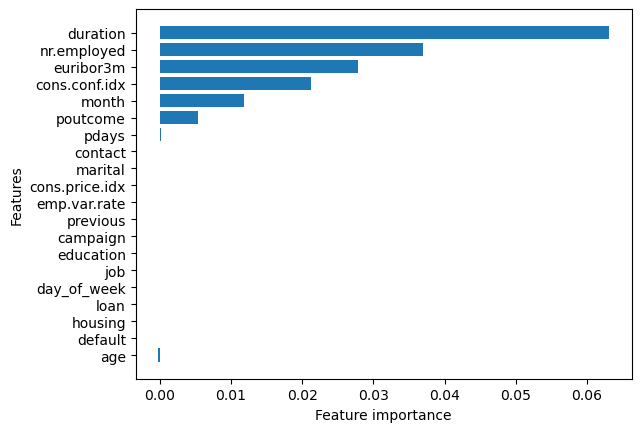

In [118]:
# Get permutation importance for DecisionTree: Array Row 1
importance = permutation_importance(best_model[1], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Plot Feature Importance
plot_features(X_train.columns, importance)

### Conclusion

- After tuning up the hyperparameters, the test accuracy scores went a little higher than the basic models. We can try tuning with more combination of hyperparameters which may get a better result although it will take much longer time depending on how many more parameters we want to add.
- With the tuned hyperparameters that is used in this exercise, we can conclude that the "contact duration" seems to be important because it affects the output target the most. 